Intro

## Library Dependencies

This project relies on several key Python libraries for data collection, modeling, and analysis. **pybaseball** is used to download comprehensive baseball statistics from publicly available sources, providing access to player batting data across multiple seasons. **scikit-learn** serves as the primary machine learning framework, enabling us to build and evaluate predictive models including linear regression and random forest algorithms for batting average prediction. Finally, **statsmodels** is employed for advanced statistical modeling, specifically implementing mixed effects linear models that account for player-level random effects when predicting BABIP (Batting Average on Balls In Play). These libraries work alongside standard data science tools (pandas, numpy, matplotlib) to facilitate the complete workflow from data acquisition to model evaluation.

In [2]:
# Install libraries
!pip install pybaseball
!pip install -U scikit-learn
import sys
print(sys.executable)
!pip show statsmodels




[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
/usr/local/bin/python3


In [3]:
from pybaseball import batting_stats
import pandas as pd

# Define the seasons you want
years = [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]

# Download and combine data for all years
dfs = []
for year in years:
    df_year = batting_stats(year, qual=100)
    df_year["season"] = year
    dfs.append(df_year)

# Combine into one DataFrame
df_all = pd.concat(dfs, ignore_index=True)

# Preview and save
print(df_all.shape)
print(df_all.head())

(4375, 321)
    IDfg  Season              Name Team  Age    G   AB   PA    H   1B  ...  \
0  11579    2015      Bryce Harper  WSN   22  153  521  654  172   91  ...   
1  10155    2015        Mike Trout  LAA   23  159  575  682  172   93  ...   
2   5038    2015    Josh Donaldson  TOR   29  158  620  711  184  100  ...   
3   4314    2015        Joey Votto  CIN   31  158  545  695  171  107  ...   
4   9218    2015  Paul Goldschmidt  ARI   27  159  567  695  182  109  ...   

   HardHit  HardHit%  Events  CStr%   CSW%    xBA   xSLG  xwOBA  L-WAR  season  
0      188     0.477     394  0.118  0.226  0.293  0.543  0.418    9.3    2015  
1      205     0.486     422  0.207  0.282  0.297  0.588  0.422    9.3    2015  
2      233     0.467     499  0.145  0.255  0.279  0.542  0.388    8.7    2015  
3      175     0.425     412  0.177  0.254  0.289  0.542  0.423    7.3    2015  
4      197     0.465     424  0.181  0.266  0.279  0.558  0.403    7.2    2015  

[5 rows x 321 columns]


Kept 25 columns. Missing: none
(4375, 25)
      id              name team  season   pa    avg  babip  bb_rate  k_rate  \
0  11579      Bryce Harper  WSN    2015  654  0.330  0.369    0.190   0.200   
1  10155        Mike Trout  LAA    2015  682  0.299  0.344    0.135   0.232   
2   5038    Josh Donaldson  TOR    2015  711  0.297  0.314    0.103   0.187   
3   4314        Joey Votto  CIN    2015  695  0.314  0.371    0.206   0.194   
4   9218  Paul Goldschmidt  ARI    2015  695  0.321  0.382    0.170   0.217   

   sprint_speed  ...  zcontact  contact     ld     gb     fb   iffb  hr_fb  \
0           3.1  ...     0.844    0.754  0.222  0.385  0.393  0.058  0.273   
1           5.0  ...     0.877    0.800  0.244  0.372  0.384  0.025  0.253   
2           4.5  ...     0.828    0.760  0.173  0.448  0.379  0.096  0.218   
3           3.7  ...     0.825    0.791  0.250  0.422  0.328  0.015  0.216   
4           4.6  ...     0.825    0.777  0.234  0.416  0.350  0.054  0.223   

    pull   opp

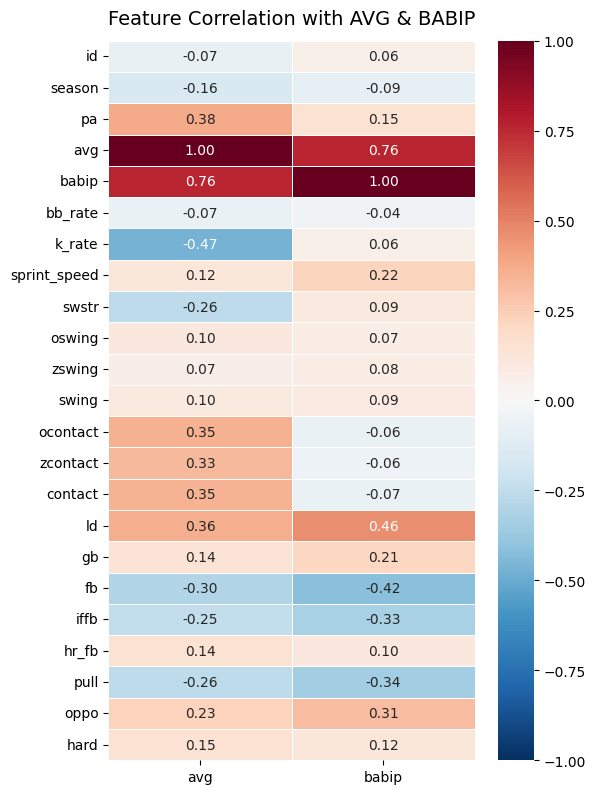


Top 10 correlated features with AVG:
avg         1.000000
babip       0.764403
pa          0.378146
ld          0.362976
ocontact    0.354882
contact     0.348364
zcontact    0.325951
oppo        0.227152
hard        0.150667
hr_fb       0.143744
Name: avg, dtype: float64

Top 10 correlated features with BABIP:
babip           1.000000
avg             0.764403
ld              0.462252
oppo            0.310882
sprint_speed    0.223371
gb              0.211896
pa              0.154171
hard            0.122089
hr_fb           0.102365
swstr           0.094952
Name: babip, dtype: float64


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# columns we want to consider
cols = [
    'IDfg','Name','Team','Season','PA','AVG','BABIP','BB%','K%','Spd',
    'SwStr%','O-Swing%','Z-Swing%','Swing%','O-Contact%','Z-Contact%','Contact%',
    'LD%','GB%','FB%','IFFB%','HR/FB','Pull%','Oppo%','Hard%'
]

# keep only the intersection
available = [c for c in cols if c in df_all.columns]
missing = [c for c in cols if c not in df_all.columns]

df_focus = df_all[available].copy()
print(f"Kept {len(available)} columns. Missing: {missing if missing else 'none'}")

# standardize column names to snake_case
rename_map = {
    'IDfg': 'id', 'Name': 'name', 'Team': 'team', 'Season': 'season', 'PA': 'pa',
    'AVG': 'avg', 'BABIP': 'babip', 'BB%': 'bb_rate', 'K%': 'k_rate', 'Spd': 'sprint_speed',
    'SwStr%': 'swstr', 'O-Swing%': 'oswing', 'Z-Swing%': 'zswing', 'Swing%': 'swing',
    'O-Contact%': 'ocontact', 'Z-Contact%': 'zcontact', 'Contact%': 'contact',
    'LD%': 'ld', 'GB%': 'gb', 'FB%': 'fb', 'IFFB%': 'iffb', 'HR/FB': 'hr_fb',
    'Pull%': 'pull', 'Oppo%': 'oppo', 'Hard%': 'hard'
}
df_focus.rename(columns=rename_map, inplace=True)

# Preview and save
print(df_focus.shape)
print(df_focus.head())

# filter to meaningful seasons
MIN_PA = 200
df_corr = df_focus[df_focus['pa'] >= MIN_PA].copy()

# select numeric columns (ignore id/name/team)
num_cols = df_corr.select_dtypes(include=[np.number]).columns.tolist()

# compute correlation matrix
corr = df_corr[num_cols].corr()

# extract only features vs AVG and BABIP
targets = ['avg', 'babip']
corr_targets = corr[targets].copy()

# plot
plt.figure(figsize=(6, max(4, 0.35 * len(corr_targets))))
sns.heatmap(corr_targets, cmap='RdBu_r', center=0, vmin=-1, vmax=1,
            linewidths=0.5, annot=True, fmt=".2f")
plt.title("Feature Correlation with AVG & BABIP", fontsize=14, pad=12)
plt.tight_layout()
plt.show()

# optional: quick sorted correlations to inspect top signals
print("\nTop 10 correlated features with AVG:")
print(corr_targets['avg'].sort_values(ascending=False).head(10))
print("\nTop 10 correlated features with BABIP:")
print(corr_targets['babip'].sort_values(ascending=False).head(10))

### Data Cleaning and Processing

Before building predictive models, it's essential to clean and preprocess our data. This section covers key steps required to prepare our dataset for machine learning, including handling missing values, removing duplicates, encoding categorical variables, dealing with outliers, and ensuring data type consistency.

### Step 1: Setup and Exploratory Data Analysis

First, we'll import the necessary libraries and examine the initial state of our dataset. This helps us understand the data structure, identify missing values, and get a sense of what cleaning steps will be needed.


In [6]:
import pandas as pd
import numpy as np

# Start with the focused dataset
df_clean = df_focus.copy()
print(f"Starting: {df_clean.shape}")

# 1. EXPLORATORY DATA ANALYSIS
print("\n1. Data Info:")
print(f"Shape: {df_clean.shape}")
print(f"Missing values: {df_clean.isnull().sum().sum()}")
print(f"Data types: {df_clean.dtypes.value_counts().to_dict()}")


Starting: (4375, 25)

1. Data Info:
Shape: (4375, 25)
Missing values: 0
Data types: {dtype('float64'): 20, dtype('int64'): 3, dtype('O'): 2}


### Step 2: Remove Columns with Excessive Missing Data

Columns with more than 50% missing values are typically not useful for modeling and can introduce noise. We'll identify and remove these columns to keep our dataset clean and focused on features with sufficient data.


In [15]:
# 2. REMOVE COLUMNS WITH LOTS OF MISSING DATA (>50%)
missing_pct = (df_clean.isnull().sum() / len(df_clean)) * 100
cols_to_drop = missing_pct[missing_pct > 50].index.tolist()
if cols_to_drop:
    df_clean = df_clean.drop(columns=cols_to_drop)
    print(f"\n2. Removed {len(cols_to_drop)} columns with >50% missing data")
else:
    print(f"\n2. No columns with >50% missing data (0 columns removed)")



2. No columns with >50% missing data (0 columns removed)


### Step 3: Remove Duplicate Player-Season Combinations

Sometimes the same player-season combination may appear multiple times in the dataset (e.g., if a player was traded mid-season). We'll keep only the record with the highest plate appearances (PA) for each player-season combination, as this likely represents the most complete data.


In [10]:
# 3. REMOVE DUPLICATE PLAYERS (keep highest PA)
duplicates_before = df_clean.duplicated(subset=['name', 'season']).sum()
df_clean = df_clean.sort_values('pa', ascending=False).drop_duplicates(subset=['name', 'season'], keep='first')
print(f"\n3. Removed {duplicates_before} duplicate player-season combinations")



3. Removed 0 duplicate player-season combinations


### Step 4: Handle Text/Categorical Data

Machine learning models require numerical inputs. We need to convert categorical text data (like team names and player names) into numerical format. For team names, we'll create dummy variables (one-hot encoding). For player names, we'll create a numeric player ID that preserves the identity of each player.


In [11]:
# 4. HANDLE TEXT DATA
# Convert team to dummy variables
if 'team' in df_clean.columns:
    team_dummies = pd.get_dummies(df_clean['team'], prefix='team')
    df_clean = pd.concat([df_clean, team_dummies], axis=1).drop(columns=['team'])

# Convert name to numeric ID (simple approach without sklearn)
if 'name' in df_clean.columns:
    unique_names = df_clean['name'].unique()
    name_to_id = {name: idx for idx, name in enumerate(unique_names)}
    df_clean['player_id'] = df_clean['name'].map(name_to_id)
    df_clean = df_clean.drop(columns=['name'])

print(f"\n4. Handled text data: {df_clean.shape}")



4. Handled text data: (4375, 55)


### Step 5: Convert Data Types

Ensuring consistent data types is important for model performance and memory efficiency. We'll convert ID columns to integers and ensure all numeric columns are properly formatted as numeric types. This also helps catch any data quality issues.


In [12]:
# 5. CONVERT DATA TYPES
for col in df_clean.columns:
    if col in ['id', 'season', 'player_id']:
        df_clean[col] = df_clean[col].astype('int32')
    else:
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')


### Step 6: Remove Outliers

Extreme outliers can significantly impact model performance and may represent data errors or exceptional cases that don't reflect typical player performance. We'll use the Interquartile Range (IQR) method with a conservative 3×IQR threshold to identify and remove outliers from key statistical columns.


In [ ]:
# 6. REMOVE OUTLIERS (conservative 3*IQR rule)
# Source: https://online.stat.psu.edu/stat200/lesson/3/3.2
key_cols = ['avg', 'babip', 'pa', 'bb_rate', 'k_rate', 'sprint_speed']
initial_rows = len(df_clean)

for col in key_cols:
    if col in df_clean.columns:
        Q1, Q3 = df_clean[col].quantile([0.25, 0.75])
        IQR = Q3 - Q1
        bounds = (Q1 - 3*IQR, Q3 + 3*IQR)
        df_clean = df_clean[(df_clean[col] >= bounds[0]) & (df_clean[col] <= bounds[1])]

print(f"\n5-6. Removed {initial_rows - len(df_clean)} outliers, converted data types")



5-6. Removed 1 outliers, converted data types


### Step 7: Final Cleanup and Save

As a final step, we'll fill any remaining missing values with the median value of each column (a robust approach that isn't affected by outliers). Then we'll save the cleaned dataset to a CSV file for use in model training.


In [14]:
# 7. FINAL CLEANUP
# Fill remaining missing values
df_clean = df_clean.fillna(df_clean.median(numeric_only=True))

print(f"\n7. Final dataset: {df_clean.shape}")
print(f"Missing values: {df_clean.isnull().sum().sum()}")

# Save cleaned data
df_clean.to_csv("cleaned_batting_data.csv", index=False)
print(f"\nCleaned data saved to: cleaned_batting_data.csv")
print("DATA CLEANING COMPLETE!")



7. Final dataset: (4374, 55)
Missing values: 0

Cleaned data saved to: cleaned_batting_data.csv
DATA CLEANING COMPLETE!


In [ ]:
# Bell Train/Test Splitting
# Source: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
import pandas as pd
from sklearn.model_selection import train_test_split

# Load proccessed data
df = pd.read_csv('cleaned_batting_data.csv')

# Set X and Y
X = df.drop(columns=['avg'])
Y = df["avg"]

# Split traning and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

# Save datasets as csv
X_train.to_csv('X_train.csv', index=False)
X_test.to_csv('X_test.csv', index=False)
Y_train.to_csv('Y_train.csv', index=False)
Y_test.to_csv('Y_test.csv', index=False)

STEP 3: LINEAR REGRESSION (AVG)
Train: X=(1108, 54)  Y=(1108,)
Test:  X=(277, 54)   Y=(277,)

Performance:
Train -> MAE: 0.0032 | RMSE: 0.0044 | R2: 0.9839
Test  -> MAE: 0.0034 | RMSE: 0.0048 | R2: 0.9821

Top 15 absolute coefficients:
     feature  coefficient
0      babip     0.685177
1     k_rate    -0.346406
2         fb     0.243525
3         gb     0.182736
4      hr_fb     0.180759
5         ld     0.179948
6    bb_rate    -0.074018
7      swstr     0.066342
8      swing     0.050917
9   zcontact     0.048686
10    oswing    -0.039764
11   contact    -0.039097
12  ocontact     0.031295
13    zswing    -0.019614
14      hard     0.018156


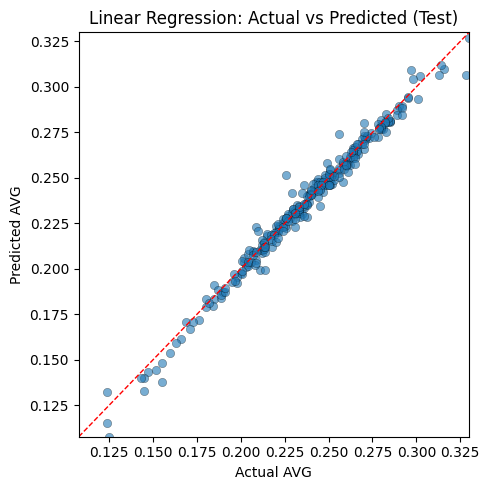


Saved model -> linear_regression_avg.pkl
Saved coefficients -> linear_regression_coefficients.csv


In [ ]:
## Linear Regression Model for Batting Average (AVG)

We'll build a baseline linear regression model to predict batting average. This model will help us understand which features are most important for predicting AVG and establish a performance baseline for comparison with more complex models.


### Step 1: Load and Prepare Data

First, we'll load the training and test datasets and ensure the target variable (batting average) is properly formatted. We'll also handle any missing values to ensure clean data for model training.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import matplotlib.pyplot as plt

# Load data
X_train = pd.read_csv("X_train.csv")
X_test  = pd.read_csv("X_test.csv")
Y_train = pd.read_csv("Y_train.csv").squeeze("columns")
Y_test  = pd.read_csv("Y_test.csv").squeeze("columns")

# Defensive: ensure target is numeric
Y_train = pd.to_numeric(Y_train, errors="coerce")
Y_test  = pd.to_numeric(Y_test, errors="coerce")

# Drop any rows with missing targets (should be none)
mask_tr = ~Y_train.isna()
mask_te = ~Y_test.isna()
X_train_lr = X_train.loc[mask_tr].copy()
Y_train_lr = Y_train.loc[mask_tr].copy()
X_test_lr  = X_test.loc[mask_te].copy()
Y_test_lr  = Y_test.loc[mask_te].copy()

print("STEP 3: LINEAR REGRESSION (AVG)")
print("=" * 40)
print(f"Train: X={X_train_lr.shape}  Y={Y_train_lr.shape}")
print(f"Test:  X={X_test_lr.shape}   Y={Y_test_lr.shape}")


### Step 2: Train the Model

We'll fit a linear regression model using scikit-learn's `LinearRegression`. This model will learn the linear relationship between our features and batting average.


In [ ]:
# Fit model
lin = LinearRegression()
lin.fit(X_train_lr, Y_train_lr)
print("Model training complete!")


### Step 3: Evaluate Model Performance

We'll evaluate the model using multiple metrics: Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and R² score. These metrics help us understand how well the model performs on both training and test data.


In [ ]:
# Make predictions
train_pred = lin.predict(X_train_lr)
test_pred  = lin.predict(X_test_lr)

# Calculate metrics
mae_tr = mean_absolute_error(Y_train_lr, train_pred)
mse_tr = mean_squared_error(Y_train_lr, train_pred)
rmse_tr = np.sqrt(mse_tr)
r2_tr = r2_score(Y_train_lr, train_pred)

mae_te = mean_absolute_error(Y_test_lr, test_pred)
mse_te = mean_squared_error(Y_test_lr, test_pred)
rmse_te = np.sqrt(mse_te)
r2_te = r2_score(Y_test_lr, test_pred)

print("\nPerformance:")
print(f"Train -> MAE: {mae_tr:.4f} | RMSE: {rmse_tr:.4f} | R2: {r2_tr:.4f}")
print(f"Test  -> MAE: {mae_te:.4f} | RMSE: {rmse_te:.4f} | R2: {r2_te:.4f}")


### Step 4: Examine Feature Coefficients

The coefficients tell us which features have the strongest impact on batting average. Positive coefficients indicate features that increase AVG, while negative coefficients indicate features that decrease AVG.


In [ ]:
# Extract and sort coefficients by absolute value
coefs = pd.Series(lin.coef_, index=X_train_lr.columns).sort_values(key=np.abs, ascending=False)
coef_df = pd.DataFrame({"feature": coefs.index, "coefficient": coefs.values})
print("\nTop 15 absolute coefficients:")
print(coef_df.head(15))

# Save coefficients for later inspection
coef_df.to_csv("linear_regression_coefficients.csv", index=False)


### Step 5: Visualize Predictions

A scatter plot of actual vs predicted values helps us visually assess model performance. Points close to the red diagonal line indicate accurate predictions.


In [ ]:
# Scatter plot: actual vs predicted (test)
plt.figure(figsize=(5,5))
plt.scatter(Y_test_lr, test_pred, alpha=0.6, edgecolor="k", linewidth=0.3)
lims = [min(Y_test_lr.min(), test_pred.min()), max(Y_test_lr.max(), test_pred.max())]
plt.plot(lims, lims, "r--", lw=1)
plt.xlim(lims); plt.ylim(lims)
plt.xlabel("Actual AVG")
plt.ylabel("Predicted AVG")
plt.title("Linear Regression: Actual vs Predicted (Test)")
plt.tight_layout()
plt.show()


### Step 6: Save the Model

We'll save the trained model and coefficients to disk so they can be loaded later for predictions or further analysis.


In [ ]:
# Save model and coefficients
joblib.dump(lin, "linear_regression_avg.pkl")
print("Saved model -> linear_regression_avg.pkl")
print("Saved coefficients -> linear_regression_coefficients.csv")


LINEAR REGRESSION (BABIP)
Train: 3499 samples, 53 features
Test:  875 samples

Train -> MAE: 0.0243 | RMSE: 0.0315 | R²: 0.4375
Test  -> MAE: 0.0252 | RMSE: 0.0322 | R²: 0.4092

Top 15 coefficients:
fb         -0.385562
gb         -0.223158
ld          0.167604
contact     0.146184
swing       0.096431
zcontact   -0.089708
hard        0.079450
ocontact   -0.078714
pull       -0.060780
swstr       0.060771
hr_fb       0.056413
zswing     -0.046091
oppo        0.045853
bb_rate     0.040331
iffb       -0.038458
dtype: float64


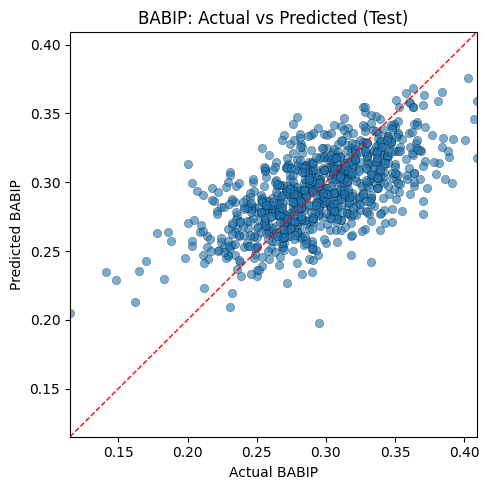

In [ ]:
## Linear Regression Model for BABIP

We'll build a separate linear regression model to predict BABIP (Batting Average on Balls In Play). This model excludes batting average as a feature since it's highly correlated with BABIP, allowing us to understand which other features drive BABIP independently.



### Step 1: Load Data and Prepare Features

We'll extract BABIP as our target variable and prepare features by excluding both BABIP (the target) and AVG (to avoid correlation issues). We'll also handle any missing values.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import matplotlib.pyplot as plt

# Load data
X_train = pd.read_csv("X_train.csv")
X_test = pd.read_csv("X_test.csv")

# Extract BABIP targets
y_train = X_train['babip'].copy()
y_test = X_test['babip'].copy()

# Prepare features: drop babip (target) and avg (too correlated)
X_train_features = X_train.drop(columns=['babip', 'avg'], errors='ignore')
X_test_features = X_test.drop(columns=['babip', 'avg'], errors='ignore')

# Remove rows with missing BABIP
valid_train = ~y_train.isna()
valid_test = ~y_test.isna()
X_train_features = X_train_features[valid_train]
y_train = y_train[valid_train]
X_test_features = X_test_features[valid_test]
y_test = y_test[valid_test]

print("LINEAR REGRESSION (BABIP)")
print("=" * 40)
print(f"Train: {X_train_features.shape[0]} samples, {X_train_features.shape[1]} features")
print(f"Test:  {X_test_features.shape[0]} samples")


### Step 2: Train the Model

We'll fit a linear regression model to learn the relationship between our features and BABIP.


In [ ]:
# Train model
model = LinearRegression()
model.fit(X_train_features, y_train)
print("Model training complete!")


### Step 3: Evaluate Model Performance

We'll evaluate the BABIP model using the same metrics as the AVG model to compare performance.


In [ ]:
# Evaluate
train_pred = model.predict(X_train_features)
test_pred = model.predict(X_test_features)

print(f"\nTrain -> MAE: {mean_absolute_error(y_train, train_pred):.4f} | "
      f"RMSE: {np.sqrt(mean_squared_error(y_train, train_pred)):.4f} | "
      f"R²: {r2_score(y_train, train_pred):.4f}")
print(f"Test  -> MAE: {mean_absolute_error(y_test, test_pred):.4f} | "
      f"RMSE: {np.sqrt(mean_squared_error(y_test, test_pred)):.4f} | "
      f"R²: {r2_score(y_test, test_pred):.4f}")


### Step 4: Examine Feature Coefficients

The coefficients show which features are most important for predicting BABIP. This helps us understand what factors influence a player's ability to get hits on balls in play.


In [ ]:
# Show top coefficients
coefs = pd.Series(model.coef_, index=X_train_features.columns).sort_values(key=abs, ascending=False)
print("\nTop 15 coefficients:")
print(coefs.head(15))


### Step 5: Visualize Predictions

A scatter plot helps us see how well the model predicts BABIP values.


In [ ]:
# Plot
plt.figure(figsize=(5, 5))
plt.scatter(y_test, test_pred, alpha=0.6, edgecolors='k', linewidth=0.3)
lims = [min(y_test.min(), test_pred.min()), max(y_test.max(), test_pred.max())]
plt.plot(lims, lims, 'r--', lw=1)
plt.xlim(lims)
plt.ylim(lims)
plt.xlabel("Actual BABIP")
plt.ylabel("Predicted BABIP")
plt.title("BABIP: Actual vs Predicted (Test)")
plt.tight_layout()
plt.show()


### Step 6: Save the Model

We'll save the trained BABIP model and coefficients for later use.
a

In [ ]:
# Save
coefs.to_frame('coefficient').to_csv("linear_regression_babip_coefficients.csv")
joblib.dump(model, "linear_regression_babip.pkl")
print("Saved model -> linear_regression_babip.pkl")
print("Saved coefficients -> linear_regression_babip_coefficients.csv")


In [ ]:
# Random Forest Model Training
# Source: https://kirenz.github.io/regression/docs/randomforest.html
from collections import OrderedDict


from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
import joblib

X_rf_train = pd.read_csv("X_train.csv")
X_rf_test = pd.read_csv("X_test.csv")
Y_rf_train = pd.read_csv("Y_train.csv")
Y_rf_test = pd.read_csv("Y_test.csv")

# currently does not inclue babip since it has a dominant effect/ hinders our ability to analyze other stats
selected_features = ["gb","fb","iffb","hard","pull","oppo","sprint_speed", "contact", "zcontact", "swing", "zswing", "oswing"]

X_rf_train = X_rf_train[selected_features]
X_rf_test = X_rf_test[selected_features]

# make flatten array
Y_rf_train = np.ravel(Y_rf_train)
Y_rf_test = np.ravel(Y_rf_test)


# define hyperparamerters
params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "warm_start":True,
    "oob_score":True,
    "random_state": 42,
}

# build model
reg =RandomForestRegressor(**params)

reg.fit(X_rf_train, Y_rf_train)

RandomForestRegressor(max_depth=4, min_samples_split=5, n_estimators=500,
                      oob_score=True, random_state=42, warm_start=True)

#make prediction
Y_pred = reg.predict(X_rf_test)

# evaluate model with MSE
rmse = np.sqrt(mean_squared_error(Y_rf_test, Y_pred,))
print("Root mean squre error:", rmse)


# obtain feature importance
feature_importance = reg.feature_importances_

# sort features according to importance
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0])

# plot feature importances
plt.barh(pos, feature_importance[sorted_idx], align="center")

plt.yticks(pos, np.array(selected_features)[sorted_idx])
plt.title("Feature Importance (MDI)")
plt.xlabel("Mean decrease in impurity");

# save model
print('saved model:')
joblib.dump(reg, "rf_avg_model.pkl")

In [ ]:
# Mixed effects Model Training with CLR transform for compositional data
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr

# --- BABIP feature selection ---
X_train = pd.read_csv("X_train.csv")
X_test  = pd.read_csv("X_test.csv")

babip_raw = ["ld","gb","fb","iffb","hard","pull","oppo","sprint_speed"]
carry_cols = ["id","season","pa"]

needed = babip_raw + carry_cols
missing_tr = [c for c in needed if c not in X_train.columns]
missing_te = [c for c in needed if c not in X_test.columns]

if missing_tr or missing_te:
    base = pd.read_csv("cleaned_batting_data.csv")
    join_keys = [k for k in ["id","season"] if k in X_train.columns and k in base.columns]
    if not join_keys:
        raise KeyError("Need join keys ('id','season') in X_train and cleaned_batting_data.csv to fetch missing columns.")
    fetch_cols = list(set(needed + join_keys))
    X_train = X_train.merge(base[fetch_cols].drop_duplicates(join_keys), on=join_keys, how="left")
    X_test  = X_test.merge(base[fetch_cols].drop_duplicates(join_keys),  on=join_keys, how="left")

X_babip_train = X_train[needed].copy()
X_babip_test  = X_test[needed].copy()

base = pd.read_csv("cleaned_batting_data.csv")

join_keys = [k for k in ["id","season"] if k in X_babip_train.columns and k in base.columns]
if not join_keys:
    raise KeyError("Need 'id' and/or 'season' in both X_babip_* and cleaned_batting_data.csv")

train_babip = X_babip_train.merge(
    base[join_keys + ["babip"]].drop_duplicates(join_keys),
    on=join_keys, how="left"
)
test_babip = X_babip_test.merge(
    base[join_keys + ["babip"]].drop_duplicates(join_keys),
    on=join_keys, how="left"
)

train_babip = train_babip.dropna(subset=["babip"]).copy()

# =============== CLR TRANSFORMATION FOR COMPOSITIONAL DATA ===============
def centered_log_ratio(df, comp_cols):
    """
    Apply centered log-ratio transform to compositional columns.
    CLR(x) = log(x) - mean(log(x)) for each row.
    """
    comp_data = df[comp_cols].values
    comp_data = np.clip(comp_data, 1e-6, 1)  # avoid log(0)
    log_comp = np.log(comp_data)
    log_mean = log_comp.mean(axis=1, keepdims=True)
    clr = log_comp - log_mean
    clr_cols = [f"clr_{c}" for c in comp_cols]
    return pd.DataFrame(clr, columns=clr_cols, index=df.index)

# --- Re-express IFFB and FB on the BIP scale ---
for _df in (train_babip, test_babip):
    _df["iffb_bip"] = (_df["fb"] * _df["iffb"]).clip(lower=0, upper=1)
    _df["fb_noI"]   = (_df["fb"] * (1 - _df["iffb"])).clip(lower=0, upper=1)

# Apply CLR to batted ball composition (LD, GB, FB_noIFFB) on the BIP scale
comp_cols = ["ld", "gb", "fb_noI"]
other_features = ["iffb_bip","hard","pull","oppo","sprint_speed"]

train_clr = centered_log_ratio(train_babip, comp_cols)
test_clr  = centered_log_ratio(test_babip,  comp_cols)

# Combine CLR features with other features
train_babip_clr = pd.concat([
    train_babip[["id","season","pa","babip"]].reset_index(drop=True),
    train_clr.reset_index(drop=True),
    train_babip[other_features].reset_index(drop=True)
], axis=1)

test_babip_clr = pd.concat([
    test_babip[["id","season","pa","babip"]].reset_index(drop=True),
    test_clr.reset_index(drop=True),
    test_babip[other_features].reset_index(drop=True)
], axis=1)

# Drop clr_fb_noI - use non-IFFB fly balls as reference category
babip_fixed = ["clr_ld", "clr_gb"] + other_features

# --- Standardize all features (including CLR) ---
scaler = StandardScaler().fit(train_babip_clr[babip_fixed])
train_babip_s = train_babip_clr.copy()
test_babip_s  = test_babip_clr.copy()
train_babip_s[babip_fixed] = scaler.transform(train_babip_clr[babip_fixed])
test_babip_s[babip_fixed]  = scaler.transform(test_babip_clr[babip_fixed])

# =============== PA-weighting via row replication ===============
pa = train_babip_s["pa"].astype(float)
w_float = pa / np.median(pa)
w_int   = np.clip(np.rint(w_float), 1, 20).astype(int)

idx = np.arange(len(train_babip_s))
rep_idx = np.repeat(idx, w_int)
train_exp = train_babip_s.iloc[rep_idx].copy()

# MixedLM setup
train_exp["id"] = train_exp["id"].astype("category")
test_babip_s["id"]  = test_babip_s["id"].astype("category")

# Model formula with ONLY clr_ld and clr_gb (NOT clr_fb)
formula = "babip ~ " + " + ".join(babip_fixed)

# Try multiple fitting methods
md = smf.mixedlm(
    formula=formula,
    data=train_exp,
    groups=train_exp["id"],
    re_formula="1"
)

fit_babip = None
methods = [
    ("lbfgs", {"maxiter": 500, "reml": True}),
    ("bfgs", {"maxiter": 500, "reml": True}),
    ("powell", {"maxiter": 500, "reml": True})
]

for method, kwargs in methods:
    try:
        fit_babip = md.fit(method=method, **kwargs, disp=False)
        if fit_babip.converged:
            break
    except Exception as e:
        continue

if fit_babip is None:
    raise RuntimeError("All optimization methods failed")

# Predictions
train_pred = fit_babip.predict(train_babip_s)
test_pred  = fit_babip.predict(test_babip_s)

# =============== MODEL EVALUATION ===============
def wmae(y, yhat, w):
    return np.average(np.abs(y - yhat), weights=w)

def wrmse(y, yhat, w):
    return np.sqrt(np.average((y - yhat)**2, weights=w))

y_tr, y_te = train_babip_s["babip"].values, test_babip_s["babip"].values
w_tr, w_te = train_babip_s["pa"].values,     test_babip_s["pa"].values

print("\n" + "="*70)
print("BABIP MODEL PERFORMANCE")
print("="*70)

# Training metrics
train_mae = mean_absolute_error(y_tr, train_pred)
train_rmse = np.sqrt(mean_squared_error(y_tr, train_pred))
train_r2 = r2_score(y_tr, train_pred)
train_wmae = wmae(y_tr, train_pred, w_tr)
train_wrmse = wrmse(y_tr, train_pred, w_tr)

# Test metrics
test_mae = mean_absolute_error(y_te, test_pred)
test_rmse = np.sqrt(mean_squared_error(y_te, test_pred))
test_r2 = r2_score(y_te, test_pred)
test_wmae = wmae(y_te, test_pred, w_te)
test_wrmse = wrmse(y_te, test_pred, w_te)

print("\nAccuracy Metrics:")
print(f"  Train R²:        {train_r2:.4f}  |  Test R²:        {test_r2:.4f}")
print(f"  Train MAE:       {train_mae:.4f}  |  Test MAE:       {test_mae:.4f}")
print(f"  Train RMSE:      {train_rmse:.4f}  |  Test RMSE:      {test_rmse:.4f}")
print(f"  PA-Weighted MAE: {train_wmae:.4f}  |  PA-Weighted MAE: {test_wmae:.4f}")
print(f"  PA-Weighted RMSE:{train_wrmse:.4f}  |  PA-Weighted RMSE:{test_wrmse:.4f}")

# Generalization check
mae_gap = test_mae - train_mae
r2_gap = train_r2 - test_r2
print(f"\nGeneralization:")
print(f"  R² gap:  {r2_gap:+.4f} {'⚠ Possible overfitting' if r2_gap > 0.1 else '✓ Good'}")
print(f"  MAE gap: {mae_gap:+.4f} {'⚠ Possible overfitting' if mae_gap > 0.005 else '✓ Good'}")

# Random effects
re_variance = fit_babip.cov_re.iloc[0, 0] if hasattr(fit_babip, 'cov_re') else 0.0
residual_variance = fit_babip.scale
icc = re_variance / (re_variance + residual_variance)
print(f"\nRandom Effects ICC: {icc:.4f} ({icc*100:.1f}% variance is between-player)")

# =============== FEATURE IMPORTANCE ===============
print("\n" + "="*70)
print("FEATURE IMPORTANCE (Ranked by Impact)")
print("="*70)

params = fit_babip.params
pvalues = fit_babip.pvalues

def sig_stars(p):
    if p < 0.001: return "***"
    if p < 0.01: return "**"
    if p < 0.05: return "*"
    return ""

# Collect all features with their coefficients
feature_impacts = []
feature_names = {
    "clr_ld": "Line Drives (vs FB)",
    "clr_gb": "Ground Balls (vs FB)",
    "iffb_bip": "Infield Fly Balls",
    "hard": "Hard Contact",
    "pull": "Pull Direction",
    "oppo": "Opposite Field",
    "sprint_speed": "Sprint Speed"
}

for coef_name in babip_fixed:
    if coef_name in params:
        val = params[coef_name]
        p = pvalues.get(coef_name, 1.0)
        display_name = feature_names.get(coef_name, coef_name)
        feature_impacts.append((display_name, val, p))

# Sort by absolute value of coefficient (impact magnitude)
feature_impacts.sort(key=lambda x: abs(x[1]), reverse=True)

print("\nRanked by magnitude (standardized coefficients):")
for i, (name, coef, p) in enumerate(feature_impacts, 1):
    direction = "↑" if coef > 0 else "↓"
    print(f"  {i}. {name:25s} {direction} {abs(coef):.4f} {sig_stars(p)}")

print("\n(*** p<0.001, ** p<0.01, * p<0.05)")

# Save predictions
pred_train = train_babip_s[["id","season"]].copy()
pred_test  = test_babip_s[["id","season"]].copy()
pred_train["babip_actual"] = y_tr
pred_train["babip_pred"] = train_pred
pred_train["residual"] = y_tr - train_pred
pred_test["babip_actual"] = y_te
pred_test["babip_pred"] = test_pred
pred_test["residual"] = y_te - test_pred

pred_train.to_csv("pred_babip_train.csv", index=False)
pred_test.to_csv("pred_babip_test.csv", index=False)
train_babip_s.to_csv("train_babip_clr_features.csv", index=False)
test_babip_s.to_csv("test_babip_clr_features.csv", index=False)

print("\n" + "="*70)
print("✓ MODEL TRAINING COMPLETE - Predictions saved")
print("="*70)

/Users/nateseluga/Downloads/Batting Average Ability/Batting-Average-Ability/.venv/lib/python3.13/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)



BABIP MODEL PERFORMANCE

Accuracy Metrics:
  Train R²:        0.3763  |  Test R²:        0.3527
  Train MAE:       0.0255  |  Test MAE:       0.0266
  Train RMSE:      0.0332  |  Test RMSE:      0.0337
  PA-Weighted MAE: 0.0226  |  PA-Weighted MAE: 0.0238
  PA-Weighted RMSE:0.0293  |  PA-Weighted RMSE:0.0300

Generalization:
  R² gap:  +0.0237 ✓ Good
  MAE gap: +0.0012 ✓ Good

Random Effects ICC: 0.1876 (18.8% variance is between-player)

FEATURE IMPORTANCE (Ranked by Impact)

Ranked by magnitude (standardized coefficients):
  1. Line Drives (vs FB)       ↑ 0.0175 ***
  2. Sprint Speed              ↑ 0.0087 ***
  3. Hard Contact              ↑ 0.0082 ***
  4. Infield Fly Balls         ↓ 0.0080 ***
  5. Ground Balls (vs FB)      ↑ 0.0067 ***
  6. Pull Direction            ↓ 0.0031 ***
  7. Opposite Field            ↑ 0.0019 *

(*** p<0.001, ** p<0.01, * p<0.05)

✓ MODEL TRAINING COMPLETE - Predictions saved


/Users/nateseluga/Downloads/Batting Average Ability/Batting-Average-Ability/.venv/lib/python3.13/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
